In [1]:
import pennylane as qml
import pennylane.numpy as np
import numpy as illegal_but_typed_np
from numpy.typing import NDArray

## 1. Set up circuit to optimize

In [10]:
from circuits import sim_02, sim_03, sim_04, sim_05

num_layers = 5
num_qubits = 4

# works as expected!
# circuit = sim_02(num_layers, num_qubits)
# initial_params = (
#     np.array(np.random.random((num_layers, num_qubits, 2))),
#     np.array([])
# )

# works as expected!
# circuit = sim_03(num_layers, num_qubits)
# initial_params = (
#     np.array(np.random.random((num_layers, num_qubits, 2))),
#     np.array(np.random.random((num_layers, num_qubits - 1)))
# )

# circuit = sim_04(num_layers, num_qubits)
# initial_params = (
#     np.array(np.random.random((num_layers, num_qubits, 2))),
#     np.array(np.random.random((num_layers, num_qubits - 1)))
# )
circuit = sim_05(num_layers, num_qubits)
initial_params = (
    np.array(np.random.random((num_layers, num_qubits, 4))),
    np.array(np.random.random((num_layers, num_qubits, num_qubits - 1)))
)

print(qml.draw(circuit)(*initial_params))

# demo circuit from Rotosolve docs, crotosolve cannot solve this
# dev = qml.device('default.qubit', wires=3, shots=None)
# @qml.qnode(dev)
# def circuit(rot_param: NDArray, layer_param: float, crot_param: NDArray):
#     for i, par in enumerate(rot_param):
#         qml.RX(par, wires=i)
#     for w in dev.wires:
#         qml.RX(layer_param, wires=w)
#     for i, par in enumerate(crot_param):
#         qml.CRY(par, wires=[i, (i+1) % 3])
#     return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1) @ qml.PauliZ(2))
# params = (
#     np.array([0.3, 0.2, 0.67], requires_grad=True),
#     np.array(1.1, requires_grad=True),
#     np.array([-0.2, 0.1, -2.5], requires_grad=True)
# )

0: ──RX(0.35)──RZ(0.07)─────────────────────╭RZ(0.16)─────────────────────╭RZ(0.03)──────────
1: ──RX(0.74)──RZ(0.25)───────────╭RZ(0.78)─│───────────────────╭RZ(0.98)─│─────────╭●───────
2: ──RX(0.66)──RZ(0.14)─╭RZ(0.71)─│─────────│─────────╭●────────╰●────────╰●────────│────────
3: ──RX(0.98)──RZ(0.60)─╰●────────╰●────────╰●────────╰RZ(0.08)─────────────────────╰RZ(0.91)

────────────╭RZ(0.26)─╭●────────╭●────────╭●─────────RX(0.51)──RZ(0.65)──||──RX(0.56)──RZ(0.84)
──╭●────────╰●────────│─────────│─────────╰RZ(0.94)──RX(0.41)──RZ(0.48)──||──RX(0.31)──RZ(0.50)
──╰RZ(0.34)───────────│─────────╰RZ(0.75)──RX(0.10)──RZ(0.74)────────────||──RX(0.48)──RZ(0.94)
──────────────────────╰RZ(0.46)──RX(0.41)──RZ(0.83)──────────────────────||──RX(0.02)──RZ(0.76)

──────────────────────╭RZ(0.54)─────────────────────╭RZ(0.18)─────────────────────╭RZ(0.65)
────────────╭RZ(0.29)─│───────────────────╭RZ(0.86)─│─────────╭●────────╭●────────╰●───────
──╭RZ(0.56)─│─────────│─────────╭●────────╰●────────╰●

## 2. Run `Crotosolve` optimization

In [11]:
from CrotosolveOptimizer import CrotosolveOptimizer

max_iterations = 5#100
convergence_threshold = 1e-06

optimizer = CrotosolveOptimizer()

cost = [(0, float(circuit(*initial_params)))]
params = initial_params
for iteration in range(max_iterations):
    with qml.Tracker(circuit.device) as tracker:
        params, prev_cost, sub_cost = optimizer.step_and_cost(
            circuit,
            *params,
            full_output=True
        )
        # assert that the #evaluations estimate is correct
        assert tracker.totals['batches'] == 1 + 2 * params[0].size + 5 * params[1].size

    sub_cost_rp = sub_cost[:params[0].size]
    sub_cost_crp = sub_cost[params[0].size:]

    evaluations_so_far = max([evs for (evs, _) in cost], default=0)
    cost.extend([
        (
            evaluations_so_far + 1 + 2 * (cost_idx + 1),
            float(cost_value)
        )
        for (cost_idx, cost_value)
        in enumerate(sub_cost_rp)
    ])

    evaluations_so_far = max([evs for (evs, _) in cost], default=0)
    cost.extend([
        (
            evaluations_so_far + 5 * (cost_idx + 1),
            float(cost_value)
        )
        for (cost_idx, cost_value)
        in enumerate(sub_cost_crp)
    ])

    if np.abs(circuit(*params) - prev_cost) <= convergence_threshold:
        print("abort", iteration)
        break

crotosolve_cost = cost

## 3. Run `Rotosolve` optimization

In [12]:
max_iterations = 5#100
convergence_threshold = 1e-06

optimizer = qml.RotosolveOptimizer()
params = initial_params

spectrum_fn = qml.fourier.qnode_spectrum(circuit)
spectra = spectrum_fn(*params)
cost = [(0, float(circuit(*initial_params)))]
for iteration in range(max_iterations):
    with qml.Tracker(circuit.device) as tracker:
        params, prev_cost, sub_cost = optimizer.step_and_cost(
            circuit,
            *params,
            spectra=spectra,
            full_output=True
        )
        assert tracker.totals['batches'] == 3 * params[0].size + 5 * params[1].size

    sub_cost_rp = sub_cost[:params[0].size]
    sub_cost_crp = sub_cost[params[0].size:]

    evaluations_so_far = max([evs for (evs, _) in cost], default=0)
    cost.extend([
        (
            evaluations_so_far + 3 * (cost_idx + 1),
            float(cost_value)
        )
        for (cost_idx, cost_value)
        in enumerate(sub_cost_rp)
    ])

    evaluations_so_far = max([evs for (evs, _) in cost], default=0)
    cost.extend([
        (
            evaluations_so_far + 5 * (cost_idx + 1),
            float(cost_value)
        )
        for (cost_idx, cost_value)
        in enumerate(sub_cost_crp)
    ])

    if np.abs(circuit(*params) - prev_cost) <= convergence_threshold:
        print("abort", iteration)
        break

rotosolve_cost = cost

540 80 60 461 540


AssertionError: 

## 4. Run `GradientDescent` optimization

In [7]:
max_iterations = 100 # 500
convergence_threshold = 1e-06

optimizer = qml.GradientDescentOptimizer()
params = initial_params

cost = [(0, float(circuit(*initial_params)))]
for iteration in range(max_iterations):
    with qml.Tracker(circuit.device) as tracker:
        params, prev_cost = optimizer.step_and_cost(
            circuit,
            *params,
        )
    evaluations_here = tracker.totals['batches']
    assert evaluations_here >= 2, "Gradient needs two evaluations!"
    current_cost = float(circuit(*params))

    evaluations_so_far = max([evs for (evs, _) in cost], default=0)
    cost.append((evaluations_so_far + evaluations_here, current_cost))

    if np.abs(current_cost - prev_cost) <= convergence_threshold:
        print("abort", iteration)
        break
    if iteration % 20 == 0:
        print(iteration, current_cost)

gradientdescent_cost = cost

0 -0.2507342071066252
20 -0.46253400979786585
40 -0.6212690664250103
60 -0.7324101646554483
80 -0.8066951423475551


## 5. Run `Adam` optimization

In [9]:
max_iterations = 100 # 500
convergence_threshold = 1e-06

optimizer = qml.AdamOptimizer()
params = initial_params

cost = [(0, float(circuit(*initial_params)))]
for iteration in range(max_iterations):
    with qml.Tracker(circuit.device) as tracker:
        params, prev_cost = optimizer.step_and_cost(
            circuit,
            *params,
        )
    evaluations_here = tracker.totals['batches']
    assert evaluations_here >= 2, "Gradient needs two evaluations!"
    current_cost = float(circuit(*params))

    evaluations_so_far = max([evs for (evs, _) in cost], default=0)
    cost.append((evaluations_so_far + evaluations_here, current_cost))

    if np.abs(circuit(*params) - prev_cost) <= convergence_threshold:
        print("abort", iteration)
        break
    if iteration % 20 == 0:
        print(iteration, current_cost)

adam_cost = cost

0 -0.2973511466473988
20 -0.9066681499084775
40 -0.989290748613225
60 -0.9981601457327064
80 -0.9998390761671443


## 5. Run `Adagrad` optimization

In [10]:
max_iterations = 100 # 500
convergence_threshold = 1e-06

optimizer = qml.AdagradOptimizer()
params = initial_params

cost = [(0, float(circuit(*initial_params)))]
for iteration in range(max_iterations):
    with qml.Tracker(circuit.device) as tracker:
        params, prev_cost = optimizer.step_and_cost(
            circuit,
            *params,
        )
    evaluations_here = tracker.totals['batches']
    assert evaluations_here >= 2, "Gradient needs two evaluations!"
    current_cost = float(circuit(*params))

    evaluations_so_far = max([evs for (evs, _) in cost], default=0)
    cost.append((evaluations_so_far + evaluations_here, current_cost))

    if np.abs(circuit(*params) - prev_cost) <= convergence_threshold:
        print("abort", iteration)
        break
    if iteration % 20 == 0:
        print(iteration, current_cost)

adagrad_cost = cost

0 -0.2973511651466259
20 -0.6187489471078944
40 -0.7500455368712033
60 -0.8263926795192191
80 -0.8735524375805135


## N. Plot loss curve

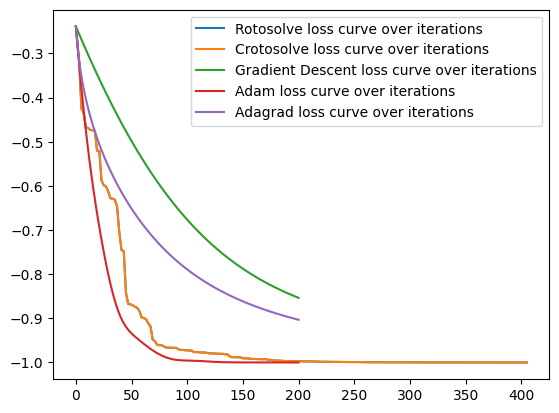

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

plot_data = [
    ("Rotosolve", rotosolve_cost),
    ("Crotosolve", crotosolve_cost),
    ("Gradient Descent", gradientdescent_cost),
    ("Adam", adam_cost),
    ("Adagrad", adagrad_cost)
]

for optimizer_name, loss_curve_data in plot_data:
    x, y = zip(*loss_curve_data) # this unzips the list of points

    ax.plot(x, y, label=f"{optimizer_name} loss curve over iterations")
    ax.legend()